In [2]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Connect to your MongoDB instance
client = MongoClient('mongodb://localhost:27017/')
db = client['vaers']  
collection = db['reports']  


# Entries per Year

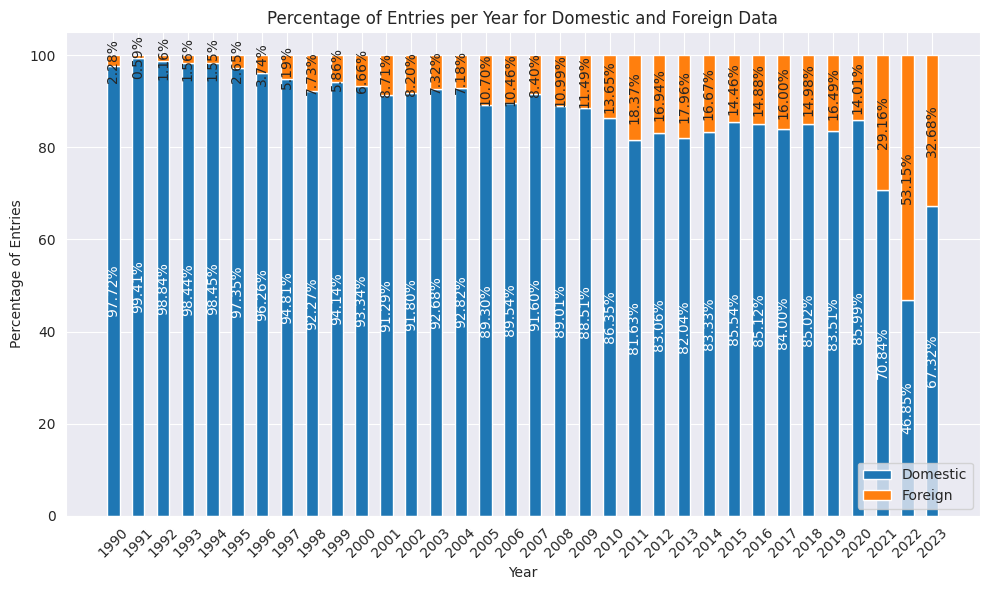

In [7]:
# Define the aggregation pipeline
pipeline = [
    {
        "$project": {
            "Year": {"$year": "$RECVDATE"},
            "is_foreign": {"$cond": [{"$eq": ["$STATE", "FR"]}, True, False]}
        }
    },
    {
        "$group": {
            "_id": {"Year": "$Year", "is_foreign": "$is_foreign"},
            "count": {"$sum": 1}
        }
    },
    {
        "$group": {
            "_id": "$_id.Year",
            "counts": {
                "$push": {
                    "is_foreign": "$_id.is_foreign",
                    "count": "$count"
                }
            }
        }
    },
    {"$sort": {"_id": 1}}
]

# Execute the aggregation pipeline
result = collection.aggregate(pipeline)

# Convert the aggregation result into a DataFrame
aggregated_data = pd.DataFrame(list(result))

# Plotting
plt.figure(figsize=(10, 6))

years = aggregated_data['_id']
domestic_counts = []
foreign_counts = []

for entry in aggregated_data['counts']:
    domestic_count = next((item['count'] for item in entry if not item['is_foreign']), 0)
    foreign_count = next((item['count'] for item in entry if item['is_foreign']), 0)
    domestic_counts.append(domestic_count)
    foreign_counts.append(foreign_count)

bar_width = 0.5
total_counts = [sum(entry['count'] for entry in counts) for counts in aggregated_data['counts']]
domestic_percentages = [domestic_count / total_count * 100 if total_count != 0 else 0 for domestic_count, total_count in zip(domestic_counts, total_counts)]
foreign_percentages = [foreign_count / total_count * 100 if total_count != 0 else 0 for foreign_count, total_count in zip(foreign_counts, total_counts)]

plt.bar(years, domestic_percentages, bar_width, label='Domestic')
plt.bar(years, foreign_percentages, bar_width, bottom=domestic_percentages, label='Foreign')

plt.title('Percentage of Entries per Year for Domestic and Foreign Data')
plt.xlabel('Year')
plt.ylabel('Percentage of Entries')
plt.xticks(years, rotation = 45)
plt.legend(loc='lower right')

# Add numbers on top of the bars
for i, year in enumerate(years):
    plt.text(year, domestic_percentages[i] / 2, f'{domestic_percentages[i]:.2f}%', ha='center', va='center', rotation=90, color = 'white')
    plt.text(year, domestic_percentages[i] + foreign_percentages[i] / 2, f'{foreign_percentages[i]:.2f}%', ha='center', va='center', rotation=90)

plt.tight_layout()
plt.savefig('/home/sebastian/Documents/Masterarbeit/Plots/Data_Exploration/Domestic_vs_NonDomestic/Entries_per_Year.png')
plt.show()

# NaN for Age and Gender

FileNotFoundError: [Errno 2] No such file or directory: '/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Domestic_vs_NonDomestic/Missing_Values_AGE_SEX.png'

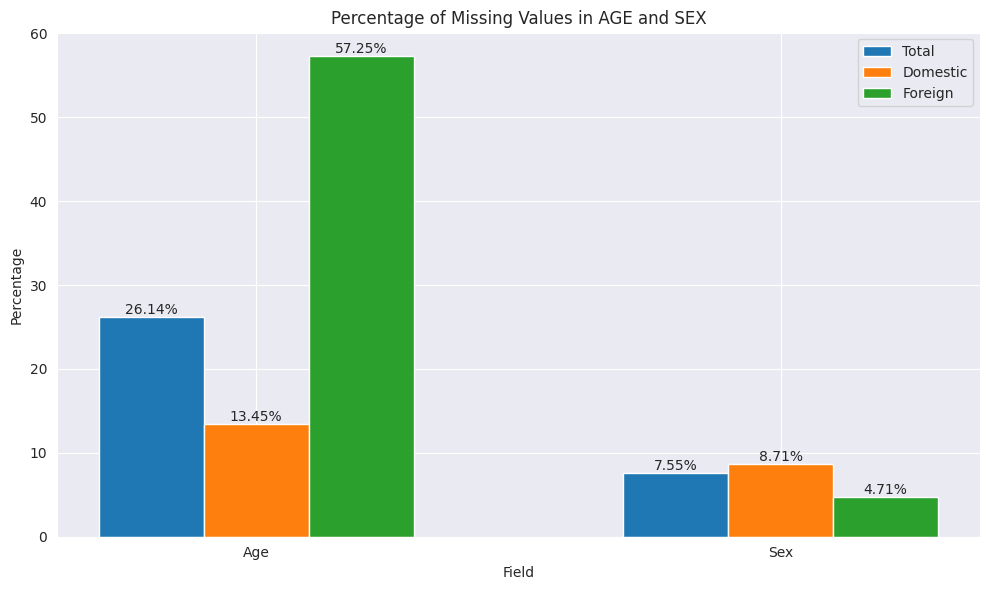

In [3]:
# Define the aggregation pipeline
pipeline = [
    {
        "$project": {
            "is_foreign": {
                "$cond": [
                    { "$eq": ["$STATE", "FR"] },  # Check if STATE is "FR"
                    1,  # If true, mark as foreign
                    0   # If false, mark as domestic
                ]
            },
            "missing_age": {
                "$cond": [
                    { "$or": [
                        { "$eq": ["$AGE", None] },
                        { "$eq": ["$AGE", ""] },
                        { "$eq": ["$AGE", np.nan] }
                    ] },
                    1,
                    0
                ]
            },
            "missing_gender": {
                "$cond": [
                    { "$or": [
                        { "$eq": ["$SEX", None] },
                        { "$eq": ["$SEX", "U"] },
                        { "$eq": ["$SEX", np.nan] }
                    ] },
                    1,
                    0
                ]
            }
        }
    },
    {
        "$group": {
            "_id": "$is_foreign",  # Group by is_foreign field (0 for domestic, 1 for foreign)
            "total_entries": { "$sum": 1 },
            "total_missing_age": { "$sum": "$missing_age" },
            "total_missing_gender": { "$sum": "$missing_gender" }
        }
    }
]

# Execute the aggregation pipeline
result = collection.aggregate(pipeline)

# Convert the aggregation result into a DataFrame
aggregated_data = pd.DataFrame(list(result))

# Calculate percentages
total_domestic_entries = aggregated_data[aggregated_data['_id'] == 0]['total_entries'].values[0]
total_foreign_entries = aggregated_data[aggregated_data['_id'] == 1]['total_entries'].values[0]

domestic_missing_age_percentage = (aggregated_data[aggregated_data['_id'] == 0]['total_missing_age'].values[0] / total_domestic_entries) * 100 if total_domestic_entries != 0 else 0
domestic_missing_gender_percentage = (aggregated_data[aggregated_data['_id'] == 0]['total_missing_gender'].values[0] / total_domestic_entries) * 100 if total_domestic_entries != 0 else 0

foreign_missing_age_percentage = (aggregated_data[aggregated_data['_id'] == 1]['total_missing_age'].values[0] / total_foreign_entries) * 100 if total_foreign_entries != 0 else 0
foreign_missing_gender_percentage = (aggregated_data[aggregated_data['_id'] == 1]['total_missing_gender'].values[0] / total_foreign_entries) * 100 if total_foreign_entries != 0 else 0

# Calculate total percentages
total_missing_age_percentage = ((aggregated_data['total_missing_age'].sum()) / (aggregated_data['total_entries'].sum())) * 100
total_missing_gender_percentage = ((aggregated_data['total_missing_gender'].sum()) / (aggregated_data['total_entries'].sum())) * 100

# Plotting
plt.figure(figsize=(10, 6))

bar_width = 0.2
index = np.arange(2)

# Plotting total bars first
total_bars = plt.bar(index, [total_missing_age_percentage, total_missing_gender_percentage], bar_width, label='Total')

# Plotting missing age bars
domestic_bars = plt.bar(index + bar_width, [domestic_missing_age_percentage, domestic_missing_gender_percentage], bar_width, label='Domestic')
foreign_bars = plt.bar(index + 2 * bar_width, [foreign_missing_age_percentage, foreign_missing_gender_percentage], bar_width, label='Foreign')

plt.title('Percentage of Missing Values in AGE and SEX')
plt.xlabel('Field')
plt.ylabel('Percentage')
plt.xticks(index + bar_width, ['Age', 'Sex'])

# Add numbers on top of the bars
def add_numbers(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

add_numbers(total_bars)
add_numbers(domestic_bars)
add_numbers(foreign_bars)

plt.legend()
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Domestic_vs_NonDomestic/Missing_Values_AGE_SEX.png')
plt.show()


# serious reports

In [ ]:
# Define the aggregation pipeline
pipeline = [
    {
        "$group": {
            "_id": None,
            "Total": {"$sum": 1},
            "SeriousCount": {"$sum": {"$cond": [{"$eq": ["$SERIOUS", 'Y']}, 1, 0]}}
        }
    },
    {
        "$project": {
            "is_foreign": "Total",
            "Percentage": {"$multiply": [{"$divide": ["$SeriousCount", "$Total"]}, 100]}  # Calculate total percentage of serious reports
        }
    }
]

# Execute the aggregation pipeline for total
total_result = collection.aggregate(pipeline)

# Extract total percentage
total_percentage = 0
for doc in total_result:
    total_percentage = doc['Percentage']
    break  # Since there will be only one document in this aggregation result

# Define the aggregation pipeline for domestic and foreign
pipeline = [
    {
        "$project": {
            "is_foreign": {
                "$cond": [
                    { "$eq": ["$STATE", "FR"] },  # Check if STATE is "FR"
                    "Foreign",  # If true, mark as foreign
                    "Domestic"   # If false, mark as domestic
                ]
            },
            "SERIOUS": 1
        }
    },
    {
        "$group": {
            "_id": "$is_foreign",  # Group by is_foreign field ("Domestic" or "Foreign")
            "Total": {"$sum": 1},
            "SeriousCount": {"$sum": {"$cond": [{"$eq": ["$SERIOUS", 'Y']}, 1, 0]}}
        }
    },
    {
        "$project": {
            "is_foreign": "$_id",
            "Percentage": {"$multiply": [{"$divide": ["$SeriousCount", "$Total"]}, 100]}  # Calculate percentage of serious reports
        }
    }
]

# Execute the aggregation pipeline for domestic and foreign
# Execute the aggregation pipeline for domestic and foreign
result_list = list(collection.aggregate(pipeline))

# Plotting
plt.figure(figsize=(10, 6))

# Plot bar for total percentage
plt.bar("Total", total_percentage, label=f"Total")
plt.text("Total", total_percentage + 2, f'{total_percentage:.2f}%', ha='center', va='bottom')

# Iterate over the aggregation result for domestic and foreign
for doc in result_list:
    is_foreign = doc['is_foreign']
    percentage = doc['Percentage']
    if is_foreign == "Domestic":   
        # Plot bars
        plt.bar(is_foreign, percentage, label=f"{is_foreign}") 
        # Annotate bars with percentages
        plt.text(is_foreign, percentage + 2, f'{percentage:.2f}%', ha='center', va='bottom')

for doc in result_list:
    is_foreign = doc['is_foreign']
    percentage = doc['Percentage']
    if is_foreign == "Foreign":   
        # Plot bars
        plt.bar(is_foreign, percentage, label=f"{is_foreign}")
        # Annotate bars with percentages
        plt.text(is_foreign, percentage + 2, f'{percentage:.2f}%', ha='center', va='bottom')
        
plt.title('Percentage of Serious Adverse Event Reports by Origin')
plt.xlabel('Origin')
plt.ylabel('Percentage of Serious Reports')
plt.ylim(0, 100)
plt.legend()

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Domestic_vs_NonDomestic/Serious_Events.png')
plt.show()


# unknown manufacturer covid

In [ ]:
# Define the query criteria for foreign reports
foreign_query = {
    "vax_data.VAX_TYPE": {"$regex": "COVID"},
    "STATE": "FR",  # Foreign reports
    "vax_data.VAX_MANU": "UNKNOWN MANUFACTURER"
}

# Define the query criteria for domestic reports
domestic_query = {
    "vax_data.VAX_TYPE": {"$regex": "COVID"},
    "STATE": {"$ne": "FR"},
    "vax_data.VAX_MANU": "UNKNOWN MANUFACTURER"
}

# Count the occurrences of "Unknown Manufacturer" for foreign and domestic reports
foreign_unknown_count = collection.count_documents(foreign_query)
domestic_unknown_count = collection.count_documents(domestic_query)

# Count the occurrences of reports with known manufacturers for foreign and domestic reports
foreign_count = collection.count_documents({
    "vax_data.VAX_TYPE": {"$regex": "COVID"},
    "STATE": "FR"
})
domestic_count = collection.count_documents({
    "vax_data.VAX_TYPE": {"$regex": "COVID"},
    "STATE": {"$ne": "FR"}
})

# Calculate the percentage of "Unknown Manufacturer" occurrences for foreign and domestic reports
foreign_unknown_percent = (foreign_unknown_count / foreign_count) * 100 if foreign_count != 0 else 0
domestic_unknown_percent = (domestic_unknown_count / domestic_count) * 100 if domestic_count != 0 else 0

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(['Foreign Reports', 'Domestic Reports'], [foreign_unknown_percent, domestic_unknown_percent])
plt.title('Percentage of "Unknown Manufacturer" in VAX_MANU for COVID Vaccines')
plt.xlabel('Report Origin')
plt.ylabel('Percentage of Occurrences')
plt.show()


In [120]:
domestic_unknown_count

989891